In [1]:
# --------------------------------------------------------------------------------------
# Appendix of Libraries/Packages in Order of Use: Equilibrium Bids and Offers Algorithm 
# --------------------------------------------------------------------------------------

from ipywidgets import widgets, VBox, Button, Output
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import root_scalar
from scipy.integrate import quad
from scipy.interpolate import interp1d
import warnings
from scipy.integrate import IntegrationWarning
warnings.simplefilter("ignore", IntegrationWarning)
import pandas as pd
import pickle
from pathlib import Path 

In [2]:
# -------------------------------------------------------------------------------------------
# Data Generating Process for the k-DA (Section 4.1: The Model, and Data Generating Process)
# Generate vb, vs, k, prices, v_lower, c_upper
# -------------------------------------------------------------------------------------------

from ipywidgets import widgets, VBox, Button, Output
from IPython.display import display
import numpy as np

vb, vs = [], []
prices = (0.0, 1.0)
k = 0.5
v_lower = None  
c_upper = None  

# --------------------------------------------------------------
# Sorting Buyer and Seller Valuations According to N (num_vals)
# --------------------------------------------------------------

def generate_values(num_vals):
    return np.linspace(0, 1, num_vals).tolist()

# --------------------------------------------------------------------
# Algorithmic Formalization of Definition 1 (Discrete Valuation Grid)
# --------------------------------------------------------------------

def get_game(num_vals):
    global vb, vs, prices
    base_values = generate_values(num_vals)
    vb = sorted(base_values)         # ------------------
    vs = sorted(base_values.copy())  # Explicit symmetry
    prices = (0.0, 1.0)              # ------------------
    return vs, vb, prices

default_output = Output()

def calculate(b):
    default_output.clear_output()
    num_vals = num_vals_widget.value
    k_value = k_slider.value
    vs, vb, prices = get_game(num_vals)
    
    global v_lower, c_upper
    
    # -----------------------------------------
    # Algorithmic Formalization of Definiton 2
    # -----------------------------------------
    
    E = [v for v in vb if 0.1 <= v <= 0.25]
    v_lower = np.random.choice(E) if E else 0.173
    
    # -----------------------------
    # Explicit Symmetry of c_upper
    # -----------------------------
    
    c_upper = 1 - v_lower
    
    with default_output:
        print(f"Number of Possible Values: {num_vals}, k: {k_value:.3f}")
        print()
        print(f"Buyers: {[f'{v:.5f}' for v in vb]}")
        print(f"Sellers: {[f'{c:.5f}' for c in vs]}")
        print()
        print(f"Trading Range: [{v_lower:.5f}, {c_upper:.5f}]")

        
# -----------------------------------------------
# Print Parameter Selection Mechanism (Figure 1)
# -----------------------------------------------

num_vals_widget = widgets.IntSlider(
    value=5, min=5, max=1000, step=1, description='Num Values:'
)
k_slider = widgets.FloatSlider(value=k, min=0, max=1, step=0.001, description='k:')
print("MUST CLICK CALCULATE BUTTON AFTER SETTING PARAMETERS TO RECEIVE VALUES")
print("FOR HIGH OR LOW K (ie k >= .75 or k <= .25) MUST ALSO HAVE SUFFICIENT NUMBER OF POSSIBLE VALUATIONS")
calculate_button = Button(description="Calculate")
calculate_button.on_click(calculate)

default_ui = VBox([num_vals_widget, k_slider, calculate_button, default_output])
display(default_ui)

MUST CLICK CALCULATE BUTTON AFTER SETTING PARAMETERS TO RECEIVE VALUES
FOR HIGH OR LOW K (ie k >= .75 or k <= .25) MUST ALSO HAVE SUFFICIENT NUMBER OF POSSIBLE VALUATIONS


In [3]:
# --------------------------------------------------------------------
# Calculation of "Serious" Intervals for Buyer and Seller bids/offers
# --------------------------------------------------------------------

global vb_serious_interval, vs_serious_interval, serious_values_interval

# ------------------------------------------------------------------------------------------
# Algorithmic Formalization of the Contraints in Defintion 3 (Eligible Bids and Offers Intervals)
# ------------------------------------------------------------------------------------------

vb_serious_interval = (v_lower, 1.0)
vs_serious_interval = (0.0, c_upper)
serious_values_interval = (v_lower, c_upper)

# ------------------
# v_lower in [0, 1]
# ------------------

def buyer_possible_bids(v):
    """For a buyer with valuation v, return bidding interval or message"""
    if v < vb_serious_interval[0]:
        return "not in serious bids (below threshold)"
    
    interval = (vb_serious_interval[0], v)
    if interval[0] == interval[1]:
        return f"[{interval[0]:.5f}] (Only Possible Bid)"
    return interval

# ------------------
# c_upper in [0, 1]
# ------------------

def seller_possible_offers(v):
    """For a seller with valuation v, return offering interval or message"""
    if v > serious_values_interval[1]:
        return "not in serious offers (above threshold)"
    
    interval = (v, vs_serious_interval[1])
    if interval[0] == interval[1]:
        return f"[{interval[0]:.5f}] (Only Possible Offer)"
    return interval

# ---------------------------------------------------------------
# Restrict "Serious" Bids and Offers for Valuations in vb and vs
# ---------------------------------------------------------------

possible_bids = {v: buyer_possible_bids(v) for v in vb}
possible_offers = {v: seller_possible_offers(v) for v in vs}

# ---------------------------------------------------------------------
# Print "Serious Trading Intervals" (Figure 2) 
# ---------------------------------------------------------------------

print("\n" + "="*55)
print(" SERIOUS TRADING INTERVALS ".center(55, '='))
print("="*55)
print(f"Buyer Serious Interval: [{vb_serious_interval[0]:.5f}, {vb_serious_interval[1]:.5f}]")
print(f"Seller Serious Interval: [{vs_serious_interval[0]:.5f}, {vs_serious_interval[1]:.5f}]")
print(f"Trading Overlap: [{serious_values_interval[0]:.5f}, {serious_values_interval[1]:.5f}]")

# -------------------------------------------------
# Final Overlap Percentage 100(c_upper - v_lower)%
# -------------------------------------------------

print(f"→ {100*(serious_values_interval[1]-serious_values_interval[0]):.1f}% of price continuum\n")

# ----------------------------------------
# Print "Buyer Bidding Ranges" (Figure 2)
# ----------------------------------------

print("\n" + "="*55)
print(" BUYER BIDDING RANGES ".center(55, '='))
print("="*55)
for v in vb: 
    bid = possible_bids[v]
    if isinstance(bid, tuple):
        print(f"Buyer {v:.5f} | Bids: [{bid[0]:.5f}, {bid[1]:.5f}]")
    elif "(exact" in bid:
        print(f"Buyer {v:.5f} | {bid}")
    else:
        print(f"Buyer {v:.5f} | {bid}")

# ------------------------------------------
# Print "Seller Offering Ranges" (Figure 2)
# ------------------------------------------

print("\n" + "="*55)
print(" SELLER OFFERING RANGES ".center(55, '='))
print("="*55)
for v in vs:
    offer = possible_offers[v]
    if isinstance(offer, tuple):
        print(f"Seller {v:.5f} | Offers: [{offer[0]:.5f}, {offer[1]:.5f}]")
    elif "(exact" in offer:
        print(f"Seller {v:.5f} | {offer}")
    else:
        print(f"Seller {v:.5f} | {offer}")


============== SERIOUS TRADING INTERVALS ==============
Buyer Serious Interval: [0.13793, 1.00000]
Seller Serious Interval: [0.00000, 0.86207]
Trading Overlap: [0.13793, 0.86207]
→ 72.4% of price continuum


================= BUYER BIDDING RANGES ================
Buyer 0.00000 | not in serious bids (below threshold)
Buyer 0.03448 | not in serious bids (below threshold)
Buyer 0.06897 | not in serious bids (below threshold)
Buyer 0.10345 | not in serious bids (below threshold)
Buyer 0.13793 | [0.13793] (Only Possible Bid)
Buyer 0.17241 | Bids: [0.13793, 0.17241]
Buyer 0.20690 | Bids: [0.13793, 0.20690]
Buyer 0.24138 | Bids: [0.13793, 0.24138]
Buyer 0.27586 | Bids: [0.13793, 0.27586]
Buyer 0.31034 | Bids: [0.13793, 0.31034]
Buyer 0.34483 | Bids: [0.13793, 0.34483]
Buyer 0.37931 | Bids: [0.13793, 0.37931]
Buyer 0.41379 | Bids: [0.13793, 0.41379]
Buyer 0.44828 | Bids: [0.13793, 0.44828]
Buyer 0.48276 | Bids: [0.13793, 0.48276]
Buyer 0.51724 | Bids: [0.13793, 0.51724]
Buyer 0.55172 | Bids: 


=== PROCESSED VALUE SETS ===

Processed Buyer Values (vb_processed) (30 items):
[0.00000, 0.03252, 0.07322, 0.10633, 0.14224, 0.17343, 0.20739, 0.23737, 0.27487, 0.31068, 0.34162, 0.37621, 0.41607, 0.44618, 0.48489, 0.51671, 0.55199, 0.58665, 0.62333, 0.65191, 0.69329, 0.72800, 0.75665, 0.79013, 0.82611, 0.86303, 0.89839, 0.92691, 0.96589, 1.00000]

Processed Seller Values (vs_processed) (30 items):
[0.00000, 0.03656, 0.06426, 0.10307, 0.13305, 0.17724, 0.20549, 0.24061, 0.27795, 0.31248, 0.34803, 0.38132, 0.41255, 0.44408, 0.48738, 0.51701, 0.55413, 0.58871, 0.62435, 0.65587, 0.69186, 0.72195, 0.75601, 0.79330, 0.82763, 0.85788, 0.89727, 0.93369, 0.96140, 1.00000]

Processed Serious Buyer Values (vb_serious_processed) (22 items):
[0.13992, 0.17725, 0.20396, 0.23658, 0.27690, 0.30926, 0.34667, 0.38031, 0.41340, 0.45135, 0.48314, 0.51797, 0.55357, 0.58520, 0.61987, 0.65617, 0.68719, 0.72713, 0.75502, 0.79185, 0.82972, 0.86096]

Processed Serious Seller Values (vs_serious_processed) (22

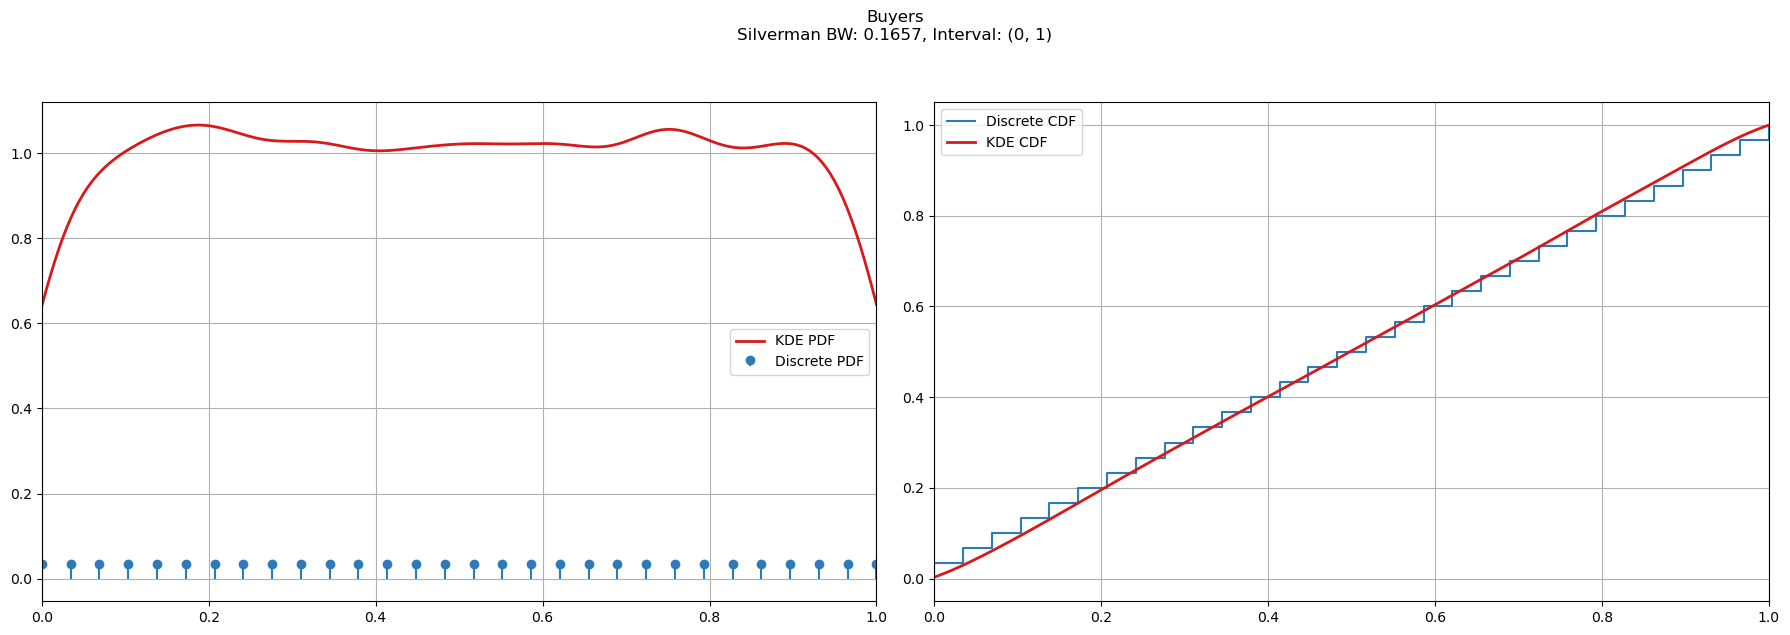

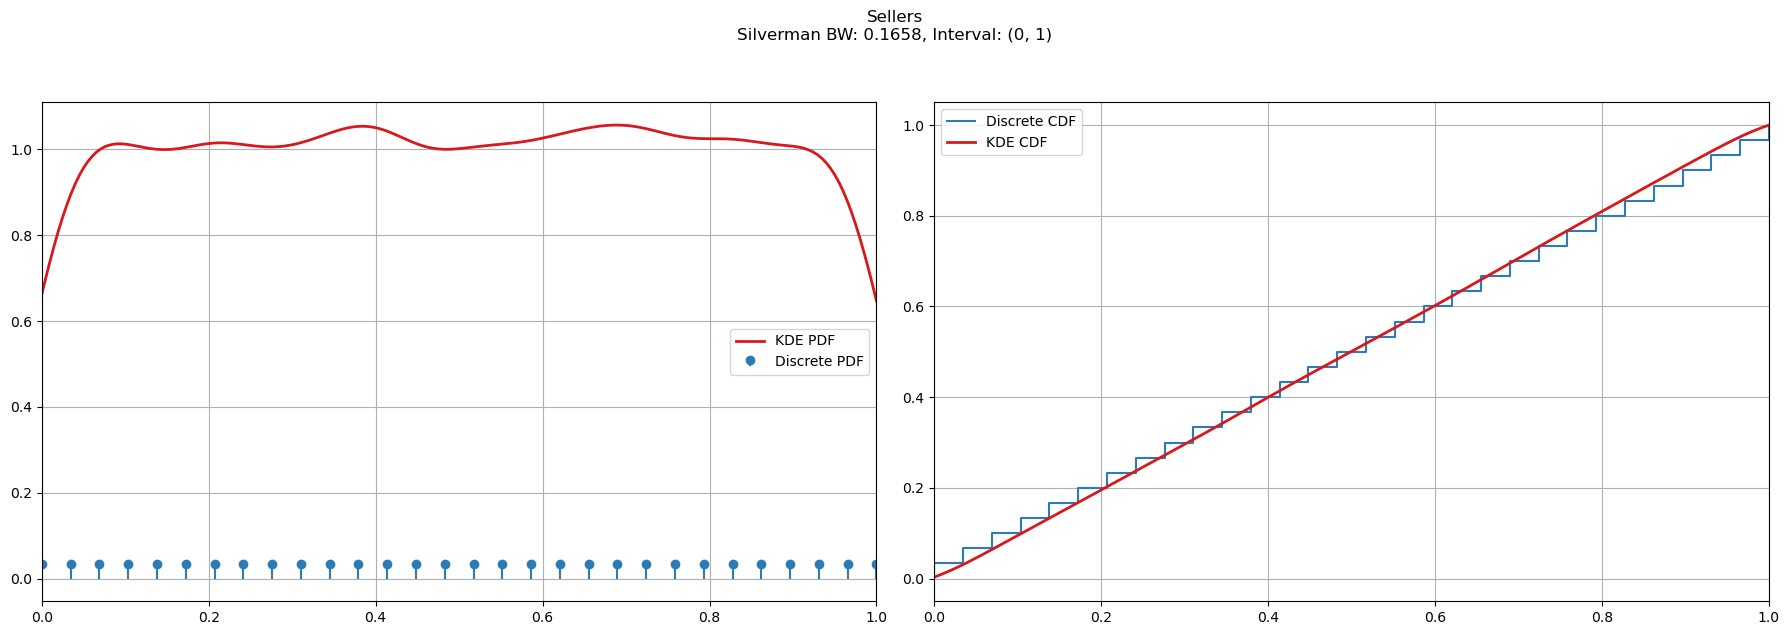


=== SERIOUS VALUE ANALYSIS ===


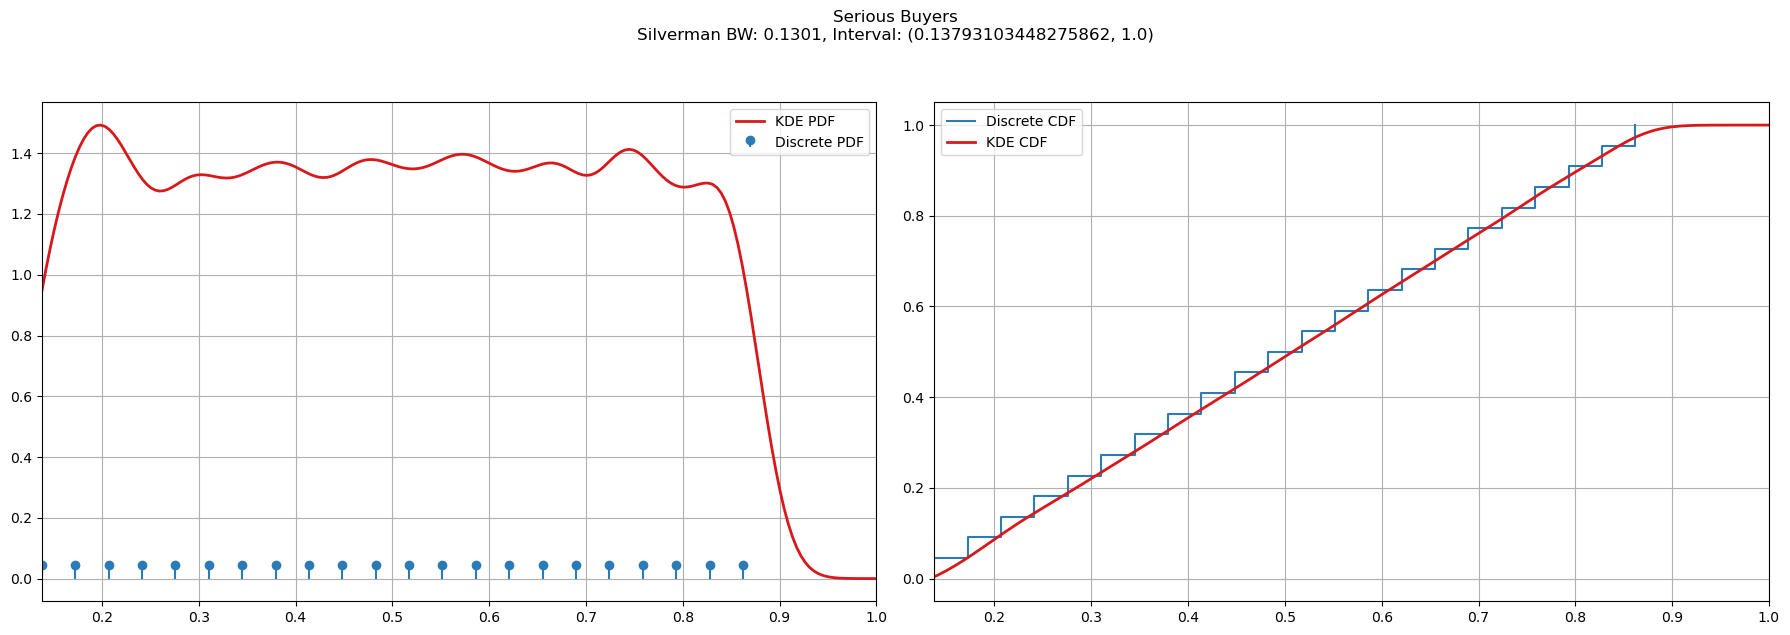

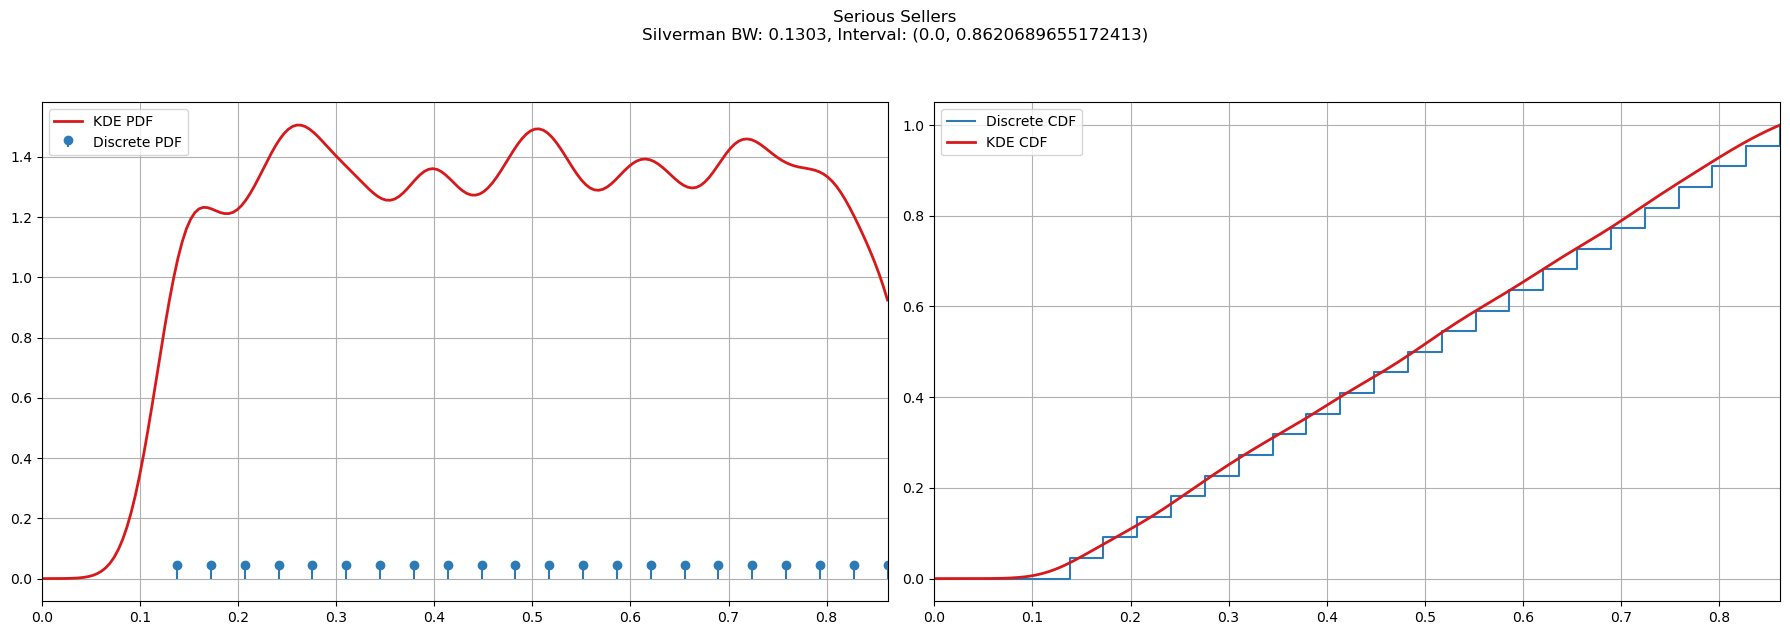

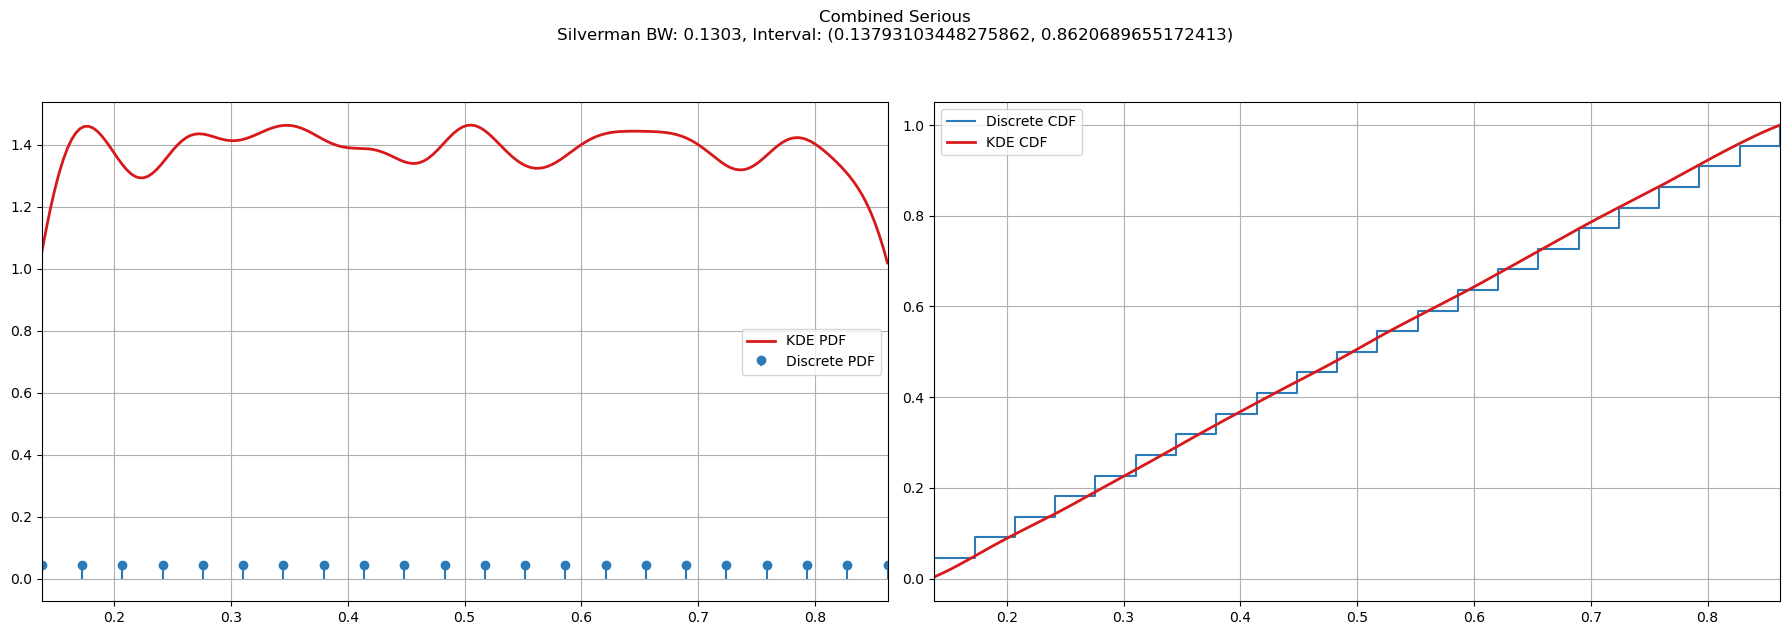


=== CORE VALIDATION ===

Validation for [0.13793, 1.00000]:
Original mean: 0.50000  Processed mean: 0.50015
Max deviation: 0.00484
Within interval: 100.00000%

Validation for [0.00000, 0.86207]:
Original mean: 0.50000  Processed mean: 0.49909
Max deviation: 0.00490
Within interval: 95.45455%

Possible Trading Pairs: 484.00000


In [4]:
# ------------------------------------------------------
# Cell 3: Enhanced Implementation with Silverman's Rule 
# (Section 4.2: Adaptation of Discrete vb and vs)
# ------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------
# Necessary Syntax for Proper Visualizations
# -------------------------------------------

def print_array(label, arr, decimals=5):
    """Print full array without truncation"""
    print(f"\n{label} ({len(arr)} items):")
    print("[" + ", ".join([f"{x:.{decimals}f}" for x in arr]) + "]")

# -----------------------------------------------------------------
# Algorithmic Formalization of Defintion 5 (Empirical PDF and CDF)
# -----------------------------------------------------------------

def compute_distribution(values):
    """Calculate discrete PDF/CDF for values"""
    unique_vals, counts = np.unique(values, return_counts=True)
    
    # ------------------------------------
    # Empirical Probability Mass Function
    # ------------------------------------
    
    pdf = counts / counts.sum()
    
    # -------------------------------------------
    # Empirical Cumulative Distribution Function
    # -------------------------------------------
    
    cdf = np.cumsum(pdf)
    return unique_vals, pdf, cdf

# -----------------------------------------------------------------------------
# Algorithmic Formalization of Method 3 (Smoothed PDF and CDF via Bounded KDE)
# -----------------------------------------------------------------------------

def compute_smoothed_distribution(values, bandwidth, data_range=(0,1)):
    """Calculate KDE-smoothed PDF/CDF with proper range handling"""
    if len(values) < 2:
        return None, None, None
    kde = gaussian_kde(values, bw_method=bandwidth)
    x_smooth = np.linspace(data_range[0], data_range[1], 200)
    pdf_smooth = kde.evaluate(x_smooth)
    
    # ----------------------------------------------------------------
    # Normalize PDF to Integrate to 1 Over the Specified Range [l, u]
    # ----------------------------------------------------------------
    
    pdf_smooth /= np.trapz(pdf_smooth, x_smooth)
    cdf_smooth = np.cumsum(pdf_smooth)
    cdf_smooth /= cdf_smooth[-1]  # Ensure CDF ends at 1
    return x_smooth, pdf_smooth, cdf_smooth

# --------------------------------------------------------------------------------
# Algorithmic Formalization of Method 1 (Adaptive Bandwidth for Bounded Support)
# --------------------------------------------------------------------------------

def adaptive_bandwidth(data, data_range=(0,1)):
    """Silverman's rule adapted for bounded support"""
    n = len(data)
    range_width = data_range[1] - data_range[0]
    
    if n < 2:                     # ----------------------------
        return 0.1 * range_width  # Base minimum on range width
                                  # ----------------------------
    
    # -------------------------------------------------------------
    # Silverman's Normal Reference Rule with Reflection Adjustment
    # -------------------------------------------------------------
    
    sigma = np.std(data, ddof=1)
    reflection_factor = 1 + (sigma**2)/(range_width**2)
    bw = 1.06 * sigma * (n ** (-0.2)) * (reflection_factor ** 0.2)
    
    # ---------------------------------------------
    # Bandwidth Constraints to Avoid Oversmoothing
    # ---------------------------------------------
    
    return np.clip(bw, 0.05 * range_width, 0.5 * range_width)

# -----------------------------------------------------------
# Algorithmic Formalization of Method 2 (Boundary Jittering)
# -----------------------------------------------------------

def preprocess_valuations(values, epsilon=0.005):
    """Uniform-optimized jittering"""
    processed = []
    for v in values:
        if np.isclose(v, 0) or np.isclose(v, 1):
            processed.append(v)
        else:                                              # --------------------------
            jitter = np.random.uniform(-epsilon, epsilon)  # epsilon ~ (-delta, delta)
            processed.append(np.clip(v + jitter, 0, 1))    # --------------------------
    return np.array(processed)

# ----------------------------------------------------
# Applying the Processing Procedures for Definition 6
# ----------------------------------------------------

v_lower = serious_values_interval[0]
c_upper = serious_values_interval[1]

vb_serious_orig = [v for v in vb if v_lower <= v <= c_upper]  
vs_serious_orig = [v for v in vs if v_lower <= v <= c_upper] 
serious_values_orig = np.intersect1d(vb_serious_orig, vs_serious_orig)

# ----------------------------------------
# Print "Processed Value Sets" (Figure 3)
# ----------------------------------------

print("\n=== PROCESSED VALUE SETS ===")
vb_processed = preprocess_valuations(vb)
print_array("Processed Buyer Values (vb_processed)", vb_processed)

vs_processed = preprocess_valuations(vs)
print_array("Processed Seller Values (vs_processed)", vs_processed)

vb_serious_processed = preprocess_valuations(vb_serious_orig)
print_array("Processed Serious Buyer Values (vb_serious_processed)", vb_serious_processed)

vs_serious_processed = preprocess_valuations(vs_serious_orig)
print_array("Processed Serious Seller Values (vs_serious_processed)", vs_serious_processed)

serious_processed = preprocess_valuations(serious_values_orig)
print_array("Processed Combined Serious Values (serious_processed)", serious_processed)

# -----------------------
# Bandwidth Calculations
# -----------------------

bw_vb = adaptive_bandwidth(vb_processed, (0,1))
bw_vs = adaptive_bandwidth(vs_processed, (0,1))
bw_vb_serious = adaptive_bandwidth(vb_serious_processed, (v_lower, c_upper))
bw_vs_serious = adaptive_bandwidth(vs_serious_processed, (v_lower, c_upper))
bw_serious = adaptive_bandwidth(serious_processed, (v_lower, c_upper))

# ------------------------------------------------------
# Enhanced Visualization of the Processed Distributions
# ------------------------------------------------------

def plot_combined_distributions(original, processed, bw, title, interval):
    """Enhanced visualization with Silverman bandwidth"""
    plt.figure(figsize=(18, 6))
    plt.suptitle(f"{title}\nSilverman BW: {bw:.4f}, Interval: {interval}", y=1.05)
    
    # --------------------
    # PDF Plot (Figure 4)
    # --------------------
    
    plt.subplot(1, 2, 1)
    if len(original) > 0:
        unique_orig, pdf_orig, _ = compute_distribution(original)
        plt.stem(unique_orig, pdf_orig, linefmt='#2c7bb6', markerfmt='o',
                 basefmt=' ', label='Discrete PDF')
    
    if processed is not None and len(processed) > 1:
        x_smooth, pdf_smooth, _ = compute_smoothed_distribution(processed, bw, interval)
        plt.plot(x_smooth, pdf_smooth, color='#d7191c', lw=2, label='KDE PDF')
    
    plt.xlim(interval)
    plt.grid(True)
    plt.legend()
    
    # --------------------
    # CDF Plot (Figure 4)
    # --------------------
    
    plt.subplot(1, 2, 2)
    if len(original) > 0:
        _, _, cdf_orig = compute_distribution(original)
        plt.step(np.insert(unique_orig, 0, interval[0]), np.insert(cdf_orig, 0, 0),
                 where='post', color='#2c7bb6', label='Discrete CDF')
    
    if processed is not None and len(processed) > 1:
        _, _, cdf_smooth = compute_smoothed_distribution(processed, bw, interval)
        plt.plot(x_smooth, cdf_smooth, color='#d7191c', lw=2, label='KDE CDF')
    
    plt.xlim(interval)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# ------------------------
# Generate Visualizations
# ------------------------

try:
    print("\n=== VISUALIZATIONS ===")
    print("\n=== FULL DISTRIBUTIONS ===")
    plot_combined_distributions(vb, vb_processed, bw_vb, "Buyers", (0, 1))
    plot_combined_distributions(vs, vs_processed, bw_vs, "Sellers", (0, 1))

    print("\n=== SERIOUS VALUE ANALYSIS ===")
    plot_combined_distributions(vb_serious_orig, vb_serious_processed, bw_vb_serious, 
                              "Serious Buyers", (v_lower, 1.0))
    plot_combined_distributions(vs_serious_orig, vs_serious_processed, bw_vs_serious, 
                              "Serious Sellers", (0.0, c_upper))
    plot_combined_distributions(serious_values_orig, serious_processed, bw_serious,
                              "Combined Serious", (v_lower, c_upper))

# -------------------------------------------------
# Store KDE results for Serious Buyers and Sellers
# -------------------------------------------------

    x_smooth_vb, pdf_smooth_vb, _ = compute_smoothed_distribution(
        vb_serious_processed, bw_vb_serious, (v_lower, 1.0))
    x_smooth_vs, pdf_smooth_vs, _ = compute_smoothed_distribution(
        vs_serious_processed, bw_vs_serious, (0.0, c_upper))
    
    global_kde_results = {
        'serious_buyer_x': x_smooth_vb,
        'serious_buyer_pdf': pdf_smooth_vb,
        'serious_seller_x': x_smooth_vs,
        'serious_seller_pdf': pdf_smooth_vs,
        'buyer_domain': (v_lower, 1.0), 
        'seller_domain': (0.0, c_upper),
        'serious_domain': (v_lower, c_upper),
        'v_lower': v_lower,
        'c_upper': c_upper,
        'vb_serious_processed': vb_serious_processed,
        'vs_serious_processed': vs_serious_processed,
        'serious_processed': serious_processed
    }
        
except Exception as e:
    print(f"Error storing KDE results: {str(e)}")

# -----------------------------------------------------
# Model Validation, Print "Core Validation"
# -----------------------------------------------------

def validate_uniform_processing(original, processed, interval):
    print(f"\nValidation for [{interval[0]:.5f}, {interval[1]:.5f}]:")
    print(f"Original mean: {np.mean(original):.5f}  Processed mean: {np.mean(processed):.5f}")
    print(f"Max deviation: {np.max(np.abs(processed - original)):.5f}")
    print(f"Within interval: {100 * np.mean((processed >= interval[0]) & (processed <= interval[1])):.5f}%")

    
print("\n=== CORE VALIDATION ===")
validate_uniform_processing(vb_serious_orig, vb_serious_processed, (v_lower, 1.0))
validate_uniform_processing(vs_serious_orig, vs_serious_processed, (0.0, c_upper))
print(f"\nPossible Trading Pairs: {len(vb_serious_orig) * len(vs_serious_orig):.5f}")

In [5]:
# -----------------------------------------------------------------------------
# Root-finding Algorithm and Formalization of the Original Model from RWS 1994
# (Section 4.3: Robust Equilibrium Implementation)
# -----------------------------------------------------------------------------

print("NOTE: THESE ERROR MESSAGES ARE THEORETICALLY SOUND, DUE TO MISREPRESENTATION NO STABLE EQUILIBRIUM SHOULD BE POSSIBLE")
from scipy.optimize import root_scalar
from scipy.integrate import quad
from scipy.interpolate import interp1d
import numpy as np
import warnings
from scipy.integrate import IntegrationWarning
warnings.simplefilter("ignore", IntegrationWarning)

# ----------------------------------------------------------------------
# Algorithmic Formalization of k-DA Baseline Strategies in Definition 7
# ----------------------------------------------------------------------

def theoretical_buyer_bid(v):
    """From RWS Equation (3.1)"""
    return v_lower + (v - v_lower) * (1 - k)

def theoretical_seller_offer(c):
    """From RWS Equation (3.2)"""
    return c_upper - (c_upper - c) * (1 - k)

# ----------------------------------------------------------------------------------
# Algorithmic Formalization of the Numerical Probability Integration in Defintion 8
# ----------------------------------------------------------------------------------

def log_K_nm(lam, m, n):
    """Log probability ≥n sellers bid ≤λ using numerical integration"""
    try:
        # ----------------------------------------------
        # Get valid integration bounds from KDE results
        # ----------------------------------------------
        
        min_c = global_kde_results['seller_domain'][0]
        max_c = global_kde_results['seller_domain'][1]
        lower = max(0.0, min_c)
        upper = min(lam, max_c)
        integ = quad(lambda x: seller_pdf_func(x), lower, upper)[0]
        return n * np.log(max(integ, 1e-100))
    except:
        return -np.inf

def log_L_nm(lam, m, n):
    """Log probability ≥m-1 buyers bid ≥λ using numerical integration"""
    try:
        # ----------------------------------------------
        # Get valid integration bounds from KDE results
        # ----------------------------------------------
        
        min_v = global_kde_results['buyer_domain'][0]
        max_v = global_kde_results['buyer_domain'][1]
        lower = max(lam, min_v)
        upper = min(1.0, max_v)
        integ = quad(lambda x: buyer_pdf_func(x), lower, upper)[0]
        return (m-1) * np.log(max(integ, 1e-100))
    except:
        return -np.inf

def log_M_nm(lam, m, n):
    """Combined numerical integration with domain awareness"""
    try:
        # -------------------------
        # Buyer survival component
        # -------------------------
        
        b_min = global_kde_results['buyer_domain'][0]
        b_max = global_kde_results['buyer_domain'][1]
        buyer_survival = quad(lambda x: buyer_pdf_func(x), 
                              max(lam, b_min), 
                              min(1.0, b_max))[0]
        
        # ---------------------
        # Seller CDF component
        # ---------------------
        
        s_min = global_kde_results['seller_domain'][0]
        s_max = global_kde_results['seller_domain'][1]
        seller_cdf = quad(lambda x: seller_pdf_func(x), 
                          max(0.0, s_min), 
                          min(lam, s_max))[0]
        
        return (m-1)*np.log(max(buyer_survival, 1e-100)) + n*np.log(max(seller_cdf, 1e-100))
    except:
        return -np.inf

# -----------------------------------------------------
# Parameters for Complex-Step Derivative Approximation
# -----------------------------------------------------

                        # ----------------
SAFE_DERIVATIVE = 1e-8  # delta = 10^(-8) 
                        # ----------------

                        # --------------------------------------
DERIV_EPS = 1e-20       # epsilon = 10^(-20): Complex step size
                        # --------------------------------------

# ---------------------------------------------------------------------------------------
# Algorithmic Formalization of the Complex-Step Derivative Approximation in Definition 9
# ---------------------------------------------------------------------------------------

def complex_step_derivative(func, x):
    deriv = np.imag(func(x + DERIV_EPS*1j)) / DERIV_EPS
    return np.clip(deriv, SAFE_DERIVATIVE, None) if deriv > 0 else np.clip(deriv, None, -SAFE_DERIVATIVE)

# ---------------------------------------------
# Stabilized PDF Extension (KDE Interpolation)
# ---------------------------------------------

buyer_pdf_func = interp1d(
    global_kde_results['serious_buyer_x'],     # -------------------------------------
    global_kde_results['serious_buyer_pdf'],   # Linear Interpolation of Buyer Values
    bounds_error=False,                        # -------------------------------------
    
                                  # ------------------------------------
    fill_value=(1e-100, 1e-100)   # Definiton of varepsilon = 10^(-100)
)                                 # ------------------------------------

seller_pdf_func = interp1d(
    global_kde_results['serious_seller_x'],    # --------------------------------------
    global_kde_results['serious_seller_pdf'],  # Linear Interpolation of Seller Values
    bounds_error=False,                        # --------------------------------------
    fill_value=(1e-100, 1e-100)
)

# ------------------------------------------------------
# Stabilized First-Order-Condition Solver from Method 4
# ------------------------------------------------------

                 # ----------------------------------------------------
LOG_CLAMP = 700  # Log-clamping Parameter from Remark 2, and Elsewhere
                 # ----------------------------------------------------
    
# --------------------------------------------
# Buyer-Equilibrium Computation from Method 5
# --------------------------------------------

def buyer_foc(lam, v, m, n):
    if lam < v_lower or lam > c_upper:
        return np.inf if lam < v_lower else -np.inf

    try:
        f = max(seller_pdf_func(lam), 1e-100)
        g = max(buyer_pdf_func(v), 1e-100)
        
        dB = complex_step_derivative(theoretical_buyer_bid, v)
        dS = complex_step_derivative(theoretical_seller_offer, lam)
        
        # -------------------------------------------------------------------------
        # Log-space calculations with overflow protection from Equations (15)-(17)
        # -------------------------------------------------------------------------
        
        log_K = np.clip(log_K_nm(lam, m, n), -LOG_CLAMP, LOG_CLAMP)
        log_L = np.clip(log_L_nm(lam, m, n), -LOG_CLAMP, LOG_CLAMP)
        log_M = np.clip(log_M_nm(lam, m, n), -LOG_CLAMP, LOG_CLAMP)
        
        K = np.exp(log_K) if abs(log_K) < LOG_CLAMP else 0.0
        L = np.exp(log_L) if abs(log_L) < LOG_CLAMP else 0.0
        M = np.exp(log_M) if abs(log_M) < LOG_CLAMP else 0.0
        
        # -------------------------------------------
        # Core FOC Calculation [Exact Equation (15)]
        # -------------------------------------------
        
        term1 = (v - k) * (n * K * f / max(abs(dS), SAFE_DERIVATIVE) + 
                           (m-1) * L * g / max(abs(dB), SAFE_DERIVATIVE))
        term2 = k * M
        return term1 - term2
    except Exception as e:
        print(f"FOC error at v={v:.4f}, λ={lam:.4f}: {str(e)}")
        return np.inf

# ------------------------------------------------------------------
# 4. Buyer Equilibrium Calculation with Safe Brackets from Method 5
# ------------------------------------------------------------------

def calculate_buyer_equilibrium():
    equilibrium = {}
    m = len(vb_serious_processed)
    n = len(vs_serious_processed)
    
    bid_min = v_lower
    bid_max = c_upper
    
    buyer_warning_printed = False
    
    for v in vb_serious_processed:
        try:
            theory_bid = theoretical_buyer_bid(v)
            safe_bracket = (
                max(bid_min, theory_bid - 0.1, v_lower),
                min(bid_max, theory_bid + 0.1, v)
            )
            if safe_bracket[0] >= safe_bracket[1]:
                safe_bracket = (bid_min, min(bid_max, v))
            
            # ---------------------------------------------
            # Use of the Robust 1-D Solver: Brent's Method
            # ---------------------------------------------
            
            sol = root_scalar(
                buyer_foc,
                args=(v, m, n),
                bracket=safe_bracket,
                method='brentq',
                xtol=1e-6,
                rtol=1e-5
            )
            
            equilibrium[v] = np.clip(sol.root, bid_min, bid_max)
        except Exception as e:
            if not buyer_warning_printed:
                print(f"Using theoretical bid for v={v:.4f}: {str(e)}")
                buyer_warning_printed = True
            equilibrium[v] = np.clip(theory_bid, bid_min, bid_max)
    
    return equilibrium

buyer_eq = calculate_buyer_equilibrium()

# ------------------------------------------------------------------------------------
# Algorithmic Formalization of the Extension to "all valuations" from (b) in Method 5
# ------------------------------------------------------------------------------------

def extend_buyer_equilibrium(full_valuations, eq_dict, v_lower, c_upper):

    extended_eq = {}
    
    # ------------------------------------------------------------------------------------
    # We assume eq_dict[v_lower] and eq_dict[c_upper] exist if they’re in the serious set
    # If not, we can clamp or handle them gracefully.
    # ------------------------------------------------------------------------------------
    
    B_v_lower = eq_dict.get(v_lower, theoretical_buyer_bid(v_lower))
    B_c_upper = eq_dict.get(c_upper, theoretical_buyer_bid(c_upper))
    
    for v in full_valuations:
        if v < v_lower:
            
            # -------------------------------------------
            # Project downward from v_lower with slope 1
            # -------------------------------------------
            
            extended_eq[v] = B_v_lower - (v_lower - v)
        elif v > c_upper:
            
            # -----------------------------------------
            # Project upward from c_upper with slope 1
            # -----------------------------------------
            
            extended_eq[v] = B_c_upper + (v - c_upper)
        else:
            if v in eq_dict:
                extended_eq[v] = eq_dict[v]
            else:
                extended_eq[v] = theoretical_buyer_bid(v)
    return extended_eq

# ------------------------------------------------------------------------------
# Algorithmic Formalization of the Seller-Equilibrium Computation from Method 6
# ------------------------------------------------------------------------------

def calculate_seller_equilibrium():
    equilibrium = {}
    warned_bracket_issue = False
    bids = np.array(list(buyer_eq.values()))
    
    # -----------------------------------------------
    # Algorithmic Formalization of (a) from Method 6
    # -----------------------------------------------
    
    serious_sellers = serious_processed
    offers = [
        c_upper - (c_upper - v_lower) * (1 - k) * (c / c_upper) 
        for c in serious_sellers
    ]
    
    for c in serious_sellers:
        try:
                                 # ----------------------------------------------
            def seller_foc(a):   # Seller First-Order Condition, (b) in Method 6
                                 # ----------------------------------------------
                
                numerator = quad(lambda x: buyer_pdf_func(x), a, c_upper)[0]
                denominator = max(buyer_pdf_func(a), 1e-100)
                return (a - c) - (numerator / denominator)
            
            bracket_low = max(c, v_lower)
            bracket_high = min(c_upper, c + 0.1*(c_upper - v_lower))
            sol = root_scalar(
                seller_foc,
                bracket=[bracket_low, bracket_high],
                
                                   # --------------------------------------------
                method='brentq',   # Root Finding Algorithm using Brent's Method
                                   # --------------------------------------------
                
                xtol=1e-6
            )
            
            equilibrium[c] = np.clip(sol.root, c, c_upper)
        except Exception as e:
            if not warned_bracket_issue:
                print(f"Warning: Seller root-finding failed for c={c:.4f}. Using theoretical offer. Error: {str(e)}")
                warned_bracket_issue = True
            equilibrium[c] = np.clip(theoretical_seller_offer(c), c, c_upper)
    
    return equilibrium
seller_eq = calculate_seller_equilibrium()

# ----------------------------------------------
# Agorithmic Formalization of (b) from Method 6
# ----------------------------------------------

def extend_seller_equilibrium(full_valuations, eq_dict, v_lower, c_upper):
    
    extended_eq = {}
    
    S_v_lower = eq_dict.get(v_lower, theoretical_seller_offer(v_lower))
    S_c_upper = eq_dict.get(c_upper, theoretical_seller_offer(c_upper))
    
    for c in full_valuations:
        if c < v_lower:
            
            # ----------------------
            # slope=1 below v_lower
            # ----------------------
            
            extended_eq[c] = S_v_lower - (v_lower - c)
        elif c > c_upper:
            
            # ----------------------
            # slope=1 above c_upper
            # ----------------------
            
            extended_eq[c] = S_c_upper + (c - c_upper)
        else:
            if c in eq_dict:
                extended_eq[c] = eq_dict[c]
            else:
                extended_eq[c] = theoretical_seller_offer(c)
    return extended_eq

# --------------------------------------
# Algorithmic Formalization of Figure 5
# --------------------------------------

extended_buyer_eq = extend_buyer_equilibrium(vb, buyer_eq, v_lower, c_upper)
extended_seller_eq = extend_seller_equilibrium(vs, seller_eq, v_lower, c_upper)

def print_equilibrium_table():
    # Header
    print("\n" + "="*65)
    print(" STRATEGIC EQUILIBRIUM (RWS 1994 COMPATIBLE) ".center(65, '='))
    print("="*65)
    print(f"Trading Interval: [{v_lower:.4f}, {c_upper:.4f}]")
    print(f"Number of Possible Buyer Values: {len(vb_serious_processed)}, Number of Possible Seller Values: {len(vs_serious_processed)}")
    print(f"Mechanims Parameter k: {k:.2f}\n")
    
    # ---------------------------------------
    # Print "Buyer Bids (B(vb))" (Figure 5)
    # ---------------------------------------
    
    print("-"*65)
    print(" BUYER BIDS (B(vb)) ".center(65, '-'))
    print("{:<12} {:<18} {:<18} {:<10}".format("Valuation", "Computed", "Theoretical", "Δ"))
    for v in sorted(extended_buyer_eq):
        comp = extended_buyer_eq[v]
        theory = theoretical_buyer_bid(v)
        diff = comp - theory
        print(f"{v:.5f}    {comp:.5f} ({comp/theory:.2%})  {theory:.5f}       {diff:+.4f}")
    
    # ------------------------------------------
    # Print "Seller Offers (S(vs))" (Figure 5)
    # ------------------------------------------
    
    print("\n" + "-"*65)
    print(" SELLER OFFERS (S(vs)) ".center(65, '-'))
    print("{:<12} {:<18} {:<18} {:<10}".format("Cost", "Computed", "Theoretical", "Δ"))
    for c in sorted(extended_seller_eq):
        comp = extended_seller_eq[c]
        theory = theoretical_seller_offer(c)
        diff = comp - theory
        print(f"{c:.5f}    {comp:.5f} ({comp/theory:.2%})  {theory:.5f}       {diff:+.4f}")

print_equilibrium_table()

NOTE: THESE ERROR MESSAGES ARE THEORETICALLY SOUND, DUE TO MISREPRESENTATION NO STABLE EQUILIBRIUM SHOULD BE POSSIBLE
Using theoretical bid for v=0.1399: f(a) and f(b) must have different signs

========== STRATEGIC EQUILIBRIUM (RWS 1994 COMPATIBLE) ==========
Trading Interval: [0.1379, 0.8621]
Number of Possible Buyer Values: 22, Number of Possible Seller Values: 22
Mechanims Parameter k: 0.50

-----------------------------------------------------------------
----------------------- BUYER BIDS (B(vb)) ----------------------
Valuation    Computed           Theoretical        Δ         
0.00000    0.00000 (0.00%)  0.06897       -0.0690
0.03448    0.03448 (40.00%)  0.08621       -0.0517
0.06897    0.06897 (66.67%)  0.10345       -0.0345
0.10345    0.10345 (85.71%)  0.12069       -0.0172
0.13793    0.13793 (100.00%)  0.13793       +0.0000
0.17241    0.15517 (100.00%)  0.15517       +0.0000
0.20690    0.17241 (100.00%)  0.17241       +0.0000
0.24138    0.18966 (100.00%)  0.18966       +0.0

In [6]:
# ---------------------------------------------------- 
# Equilibrium Condition Verification from Section 4.4
# ----------------------------------------------------

import numpy as np

# -------------------------------------------------
# Print "Verifying Buyer Conditions" from Figure 6
# -------------------------------------------------

print("\n" + "="*55)
print(" VERIFYING BUYER CONDITIONS ".center(55, '='))
print("="*55 + "\n")

inequality_violated = False

                             # --------------------------------
numerical_tolerance = 1e-6   # Real Parameter, gamma = 10^(-6) 
                             # --------------------------------

                   # -------------------------------
SAFE_EPS = 1e-12   # Rescaled varepsilon = 10^(-12)
                   # -------------------------------

# ---------------------------------------------
# Get Computed Equilibrium Parameters, m and n
# ---------------------------------------------

m = len(buyer_eq)
n = len(seller_eq)

# ---------------------------------------------
# Print "Market Parameters" Section (Figure 6)
# ---------------------------------------------

print(f"Market Parameters:")
print(f" Number of Possible Buyer Values: {m}, Number of Possible Seller Values: {n}")
print(f"- k value: {k:.2f}")
print(f"- Trading interval: [{v_lower:.4f}, {c_upper:.4f}]\n")

print("{:<12} {:<12} {:<12} {:<12} {:<14}".format(
    "Valuation", "Bid", "LHS", "Threshold", "Status"))
print("-"*65)

# -------------------------------------------------------------------------------
# Algorithmic Formalization of Method 7 (Stabilized Buyer Inequality Verification)
# -------------------------------------------------------------------------------

for v, lam in buyer_eq.items():
    try:
        
        # --------------------------------------------
        # Stabilized Derivative Calculation, Part (c)
        # --------------------------------------------
        
        dB = complex_step_derivative(theoretical_buyer_bid, v)
        dB = max(abs(dB), SAFE_EPS) * np.sign(dB)
        
        log_L = log_L_nm(lam, m, n)
        log_M = log_M_nm(lam, m, n)
        
        L = np.exp(log_L) if not np.isinf(log_L) else 0.0
        M = np.exp(log_M) if not np.isinf(log_M) else 0.0
        
        g_val = max(buyer_pdf_func(v), SAFE_EPS)
        
        # ---------------------------------------------------------
        # Algorithmic Formalization of Equation (21) from Method 7
        # ---------------------------------------------------------
        
        term1 = (v - lam) * (m-1) * L * (g_val / dB) if abs(dB) > SAFE_EPS else 0
        term2 = k * M
        lhs = term1 - term2
    
        if np.isinf(lhs):
            lhs = np.sign(lhs) * 1e20 
            
        status = "VIOLATED" if lhs > numerical_tolerance else "OK"
        color_code = "\033[91m" if lhs > numerical_tolerance else "\033[92m"
        
        print("{:<10.5f} | {:<10.5f} | {:<10.2e} | {:<10.2e} | {}{:<12}\033[0m".format(
            v, lam, lhs, numerical_tolerance, color_code, status))
        
        if lhs > numerical_tolerance:
            inequality_violated = True
            
    except Exception as e:
        print(f"Error verifying v={v:.5f}: {str(e)}")
        inequality_violated = True

print("\n" + "="*65)
if inequality_violated:
    print("\033[91mWARNING: Potential violations detected\033[0m")
    print("- Possible causes:")
    print("  1. Numerical approximations in density estimation")
    print("  2. Boundary effects near trading interval edges")
    print("  3. Discontinuities in strategic bidding functions")
else:
    print("\033[92mSUCCESS: Inequality holds within tolerance\033[0m")
print("="*65 + "\n")

#----------------------------------------------------------------------------------------
# Algorithmic Formalization of Method 8 (Stabilized Seller-Inequality Verification)
#----------------------------------------------------------------------------------------

print("\n" + "="*55)                                     # ----------------
print(" VERIFYING SELLER CONDITIONS ".center(55, '='))   # RHS of Figure 7
print("="*55 + "\n")                                     # ----------------

seller_inequality_violated = False
numerical_tolerance = 1e-6
SAFE_EPS = 1e-12

# -------------------------------------------
# Same Real Parameters as Buyer Verification
# -------------------------------------------

m = len(buyer_eq)
n = len(seller_eq)

print(f"Market Parameters:")
print(f"- Number of Buyer Values: {m}, Number of Seller Values: {n}")
print(f"- k value: {k:.2f}")
print(f"- Trading interval: [{v_lower:.4f}, {c_upper:.4f}]\n")

print("{:<12} {:<12} {:<12} {:<12} {:<14}".format(
    "Valuation", "Offer", "LHS", "Threshold", "Status"))
print("-"*65)

for c, sigma in seller_eq.items():
    try:
        
        # ---------------------------------------
        # Seller-specific derivative calculation
        # ---------------------------------------
        
        dS = complex_step_derivative(theoretical_seller_offer, c)
        dS = max(abs(dS), SAFE_EPS) * np.sign(dS)
        
        # ------------------------------------------
        # Seller probability terms (swap m/n roles)
        # ------------------------------------------
        
        log_K = log_K_nm(sigma, n, m)  
        log_N = log_M_nm(sigma, n, m)  
        
        K = np.exp(log_K) if not np.isinf(log_K) else 0.0
        N = np.exp(log_N) if not np.isinf(log_N) else 0.0
        
        # --------------------------------------
        # Seller Density, Floored at varepsilon
        # --------------------------------------
        
        f_val = max(seller_pdf_func(c), SAFE_EPS)
        
        # -------------------------------
        # Equation (23) from Method 8
        # -------------------------------
        
        term1 = (sigma - c) * (n-1) * K * (f_val / dS) if abs(dS) > SAFE_EPS else 0
        term2 = k * N
        lhs = term1 - term2
        
        if np.isinf(lhs):
            lhs = np.sign(lhs) * 1e20
            
        status = "VIOLATED" if lhs > numerical_tolerance else "OK"
        color_code = "\033[91m" if lhs > numerical_tolerance else "\033[92m"
        
        print("{:<10.5f} | {:<10.5f} | {:<10.2e} | {:<10.2e} | {}{:<12}\033[0m".format(
            c, sigma, lhs, numerical_tolerance, color_code, status))
        
        if lhs > numerical_tolerance:
            seller_inequality_violated = True
            
    except Exception as e:
        print(f"Error verifying c={c:.5f}: {str(e)}")
        seller_inequality_violated = True

print("\n" + "="*65)
if seller_inequality_violated:
    print("\033[91mWARNING: Seller inequality violations detected\033[0m")
    print("- Potential causes:")
    print("  1. Boundary effects in seller offer strategies")
    print("  2. Discontinuities in seller virtual valuations")
    print("  3. Numerical instability in high-density regions")
else:
    print("\033[92mSUCCESS: Seller conditions hold within tolerance\033[0m")
print("="*65 + "\n")


============== VERIFYING BUYER CONDITIONS =============

Market Parameters:
 Number of Possible Buyer Values: 22, Number of Possible Seller Values: 22
- k value: 0.50
- Trading interval: [0.1379, 0.8621]

Valuation    Bid          LHS          Threshold    Status        
-----------------------------------------------------------------
0.13992    | 0.13892    | 4.00e-02   | 1.00e-06   | VIOLATED    
0.17725    | 0.15759    | 7.42e-01   | 1.00e-06   | VIOLATED    
0.20396    | 0.17095    | 8.91e-01   | 1.00e-06   | VIOLATED    
0.23658    | 0.18725    | 7.15e-01   | 1.00e-06   | VIOLATED    
0.27690    | 0.20741    | 4.94e-01   | 1.00e-06   | VIOLATED    
0.30926    | 0.22359    | 3.60e-01   | 1.00e-06   | VIOLATED    
0.34667    | 0.24230    | 2.39e-01   | 1.00e-06   | VIOLATED    
0.38031    | 0.25912    | 1.67e-01   | 1.00e-06   | VIOLATED    
0.41340    | 0.27566    | 1.08e-01   | 1.00e-06   | VIOLATED    
0.45135    | 0.29464    | 6.45e-02   | 1.00e-06   | VIOLATED    
0.48314    

In [7]:
# ----------------------------------------------------------
# Robust Equilibrium Strategy Preservation from Section 4.5
# ----------------------------------------------------------

import pandas as pd
import pickle
from pathlib import Path

# -----------------------------------------
# Necessary Integrity Checks
# -----------------------------------------

def validate_equilibrium_dict(buyer_dict, seller_dict):
    """Ensure data integrity for downstream systems"""
    if not all(isinstance(v, float) for v in buyer_dict.keys()):
        raise ValueError("Buyer keys must be floats")
    if not all(isinstance(v, float) for v in seller_dict.keys()):
        raise ValueError("Seller keys must be floats")
    return True

# ---------------------------------------------------------------
# Algorithmic Formalization of Method 9 (Strategy Serialization)
# ---------------------------------------------------------------

try:
    validate_equilibrium_dict(extended_buyer_eq, extended_seller_eq)
    
    # ------------------------------------------------------------
    # Encode Buyer Strategies as Ordered Pairs from Equation (26) 
    # ------------------------------------------------------------
    
    df_buyers = pd.DataFrame(
        sorted(extended_buyer_eq.items(), key=lambda x: x[0]),
        columns=["Buyer Valuation", "Bid B(vb)"]
    )
    
    # ---------------------------------------------------------
    # Utility Calculation for Sellers from the End of Method 9
    # ---------------------------------------------------------
    
    df_buyers["Buyer Utility"] = df_buyers["Buyer Valuation"] - df_buyers["Bid B(vb)"]
    
    # -------------------------------------------------------------
    # Encode Seller Strategies as Ordered Pairs from Equation (27) 
    # -------------------------------------------------------------
    
    df_sellers = pd.DataFrame(
        sorted(extended_seller_eq.items(), key=lambda x: x[0]),
        columns=["Seller Valuation", "Offer S(vs)"]
    )
    
    # ---------------------------------------------------------
    # Utility Calculation for Sellers from the End of Method 9
    # ---------------------------------------------------------
    
    df_sellers["Seller Utility"] = df_sellers["Offer S(vs)"] - df_sellers["Seller Valuation"]

except Exception as e:
    raise RuntimeError(f"Data validation failed: {str(e)}") from e

# -----------------------------------------------------------------------------------------------
# Save Data, Allows Us to Upload Equilibrium Bids and Offers Data to the "Market Maker" Workbook
# -----------------------------------------------------------------------------------------------

EQUILIBRIUM_STRUCTURE = {
    "buyers": {
        "columns": ["Buyer Valuation", "Bid B(vb)", "Buyer Utility"],
        "data": df_buyers.values.tolist()
    },
    "sellers": {
        "columns": ["Seller Valuation", "Offer S(vs)", "Seller Utility"],
        "data": df_sellers.values.tolist()
    }
}

def save_equilibrium_data(data_dict):
    """Preserve exact structure for legacy systems"""
    try:
        with open("equilibrium_strategies_constrained.pkl", "wb") as f:
            pickle.dump(data_dict, f, protocol=4)
        return Path("equilibrium_strategies_constrained.pkl").stat().st_size
    except Exception as e:
        raise IOError(f"Pickle save failed: {str(e)}") from e

# ----------------------------------------------------------------------------------------
# Print Strategy Conservation of Equilibrium Bids and Offers B*(vb) and S*(vs) (Figure 8)
# ----------------------------------------------------------------------------------------

print("\nConstrained Equilibrium Strategies:\n")
print(f"Buyer Strategies B(vb) | {len(df_buyers)} agents")
print(df_buyers.to_string(index=False, float_format=lambda x: f"{x:.5f}"))
print("\n" + "-"*60)
print(f"\nSeller Strategies S(vs) | {len(df_sellers)} agents")
print(df_sellers.to_string(index=False, float_format=lambda x: f"{x:.5f}"))

file_size = save_equilibrium_data(EQUILIBRIUM_STRUCTURE)
print(f"\nStrategies saved successfully ({file_size/1024:.1f} KB)")


Constrained Equilibrium Strategies:

Buyer Strategies B(vb) | 30 agents
 Buyer Valuation  Bid B(vb)  Buyer Utility
         0.00000    0.00000        0.00000
         0.03448    0.03448        0.00000
         0.06897    0.06897        0.00000
         0.10345    0.10345        0.00000
         0.13793    0.13793        0.00000
         0.17241    0.15517        0.01724
         0.20690    0.17241        0.03448
         0.24138    0.18966        0.05172
         0.27586    0.20690        0.06897
         0.31034    0.22414        0.08621
         0.34483    0.24138        0.10345
         0.37931    0.25862        0.12069
         0.41379    0.27586        0.13793
         0.44828    0.29310        0.15517
         0.48276    0.31034        0.17241
         0.51724    0.32759        0.18966
         0.55172    0.34483        0.20690
         0.58621    0.36207        0.22414
         0.62069    0.37931        0.24138
         0.65517    0.39655        0.25862
         0.68966    0.41

In [ ]:
########################################   END OF WORKBOOK   ######################################## 